## Necessary Dependencies

In [26]:
import json
import numpy as np
import pandas as pd

In [27]:
import terminal_optimization.visualisation        as visualisation
import terminal_optimization.forecast             as forecast
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.financial_analysis   as financial
import terminal_optimization.initial_terminal     as initial

## Methods and classes to move to package

In [37]:
class Terminal:
    def __init__(self, quays=[], berths=[], cranes=[], storages=[], stations=[], q_conveyors=[], h_conveyors=[]):
        self.quays=quays
        self.berths=berths
        self.cranes=cranes
        self.storages=storages
        self.stations=stations
        self.q_conveyors=q_conveyors
        self.h_conveyors=h_conveyors

class Decision_parameters:
    pass

class Simulation_parameters:
    def __init__(self, start_year, simulation_window, operational_hours = 365*24):
        self.startyear=start_year
        self.simulation_window=simulation_window
        self.operational_hours=operational_hours

In [29]:
decision_parameters = Decision_parameters()

In [30]:
def scenario_generator(start_year, simulation_window):
    
    # Import vessels from package
    handysize = forecast.vessel(**forecast.handysize_data)
    handymax  = forecast.vessel(**forecast.handymax_data)
    panamax   = forecast.vessel(**forecast.panamax_data)
    vessels = [handysize, handymax, panamax]
    
    # Import commodities from package
    maize   = forecast.bulk_commodities(**forecast.maize_data)
    soybean = forecast.bulk_commodities(**forecast.maize_data)
    wheat   = forecast.bulk_commodities(**forecast.wheat_data)

    # Maize - Linear demand
    demand_maize  = 1000000        # demand at t=0
    growth_maize  = 100000       

    # Soybean - Exponential demand
    demand_soybean = 1000000
    rate_soybean   = 1.06          # year on year growth rate of demand (% points) - input for constant method and random method

    # Wheat - Probabilistic demand
    demand_wheat   = 1000000
    rate_wheat     = 1.05
    mu_wheat       = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
    sigma_wheat    = 0.015         # standard deviation of bonus rate (% points)   - input for random method

    # Create forecast
    maize.linear_forecast(vessels, start_year, simulation_window, demand_maize, growth_maize)
    soybean.exponential_forecast(vessels, start_year, simulation_window, demand_soybean, rate_soybean)
    wheat.random_forecast(vessels, start_year, simulation_window, demand_wheat, rate_wheat, mu_wheat, sigma_wheat)
    commodities = [maize, soybean, wheat]
    
    # Calculate yearly calls
    vessels = forecast.vessel_call_calc(maize, soybean, wheat, vessels)

    # Plot forecast
    visualisation.trend(maize, soybean, wheat, 10, 5)
    
    return vessels, commodities

In [31]:
def simulator(start_year, simulation_window, operational_hours, vessels, commodities, terminal):

    years = range (start_year, start_year + simulation_window)
    for year in years:

        timestep = year - start_year
          
        ######################
        # Investment Decisions
        ######################           
        
        # Berths
        allowable_berth_occupancy = 0.15
        berths, cranes = invest.berth_invest_decision(
            terminal.berths, 
            terminal.cranes, 
            terminal.berth_objects, 
            allowable_berth_occupancy, 
            vessels, 
            year, timestep, operational_hours)
               
        # Quay
        quays = invest.quay_invest_decision(quays, berths, quay_object, year, timestep)
        
        # Cranes (NB: isn't this a double definition of cranes?)
        cranes = invest.crane_invest_decision(cranes, berths, cranes_object, year, timestep)
        
        # Storage
        storage_type            = 'Silos'
        trigger_throughput_perc = 10  # Percentage of annual throughput which triggers the investment in a new storage unit
        aspired_throughput_perc = 20  # Aspired of annual throughput which is realised due to the new storage unit
        storages = invest.storage_invest_decision(storages, storage_object, trigger_throughput_perc, aspired_throughput_perc, storage_type, commodities, year, timestep)
        
        # Loading stations
        station_utilisation     = 0.60 # Loading station utilisation
        trigger_throughput_perc = 80   # Percentage of hourly peak demand which triggers the investment in a new loading unit
        aspired_throughput_perc = 120  # Aspired percentage of hourly peak demand which is realised due to the new loading unit
        stations = invest.station_invest_decision(stations, station_object, station_utilisation, trigger_throughput_perc, aspired_throughput_perc, commodities, year, timestep, operational_hours)

        # Conveyors
        q_conveyors = invest.quay_conveyor_invest_decision(q_conveyors, cranes, quay_conveyor_object, year, timestep, operational_hours)
        h_conveyors = invest.hinterland_conveyor_invest_decision(h_conveyors, stations, hinterland_conveyor_object, year, timestep, operational_hours)
        
        # add objects to terminal 
        for berth in berths:
            terminal.berths.append(berth)
            
        for crane in cranes:
            terminal.cranes.append(crane)

        for quay in quays:
            terminal.quays.append(quay)
            
        for storage in storages:
            terminal.storages.append(storage)
            
        for station in stations:
            terminal.stations.append(station)
            
        for q_conveyor in q_conveyors:
            terminal.q_conveyors.append(q_conveyor)

        for h_conveyor in h_conveyors:
            terminal.h_conveyors.append(h_conveyor)

        ######################
        # Business Logic
        ######################

        # Terminal throughput
        throughputs = financial.throughput_calc(throughputs, commodities, \
                                                terminal.berths, cranes, year, timestep, operational_hours)

        # Revenues
        revenues = financial.revenue_calc(revenues, commodities, throughputs, year, timestep)

        # Capex
        capex = financial.capex_calc(capex, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Labour costs
        labour = financial.labour_calc(labour, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep, operational_hours)

        # Maintenance costs
        maintenance = financial.maintenance_calc(maintenance, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Energy costs
        energy = financial.energy_calc(energy, berths, cranes, storage, stations, q_conveyors, h_conveyors, year, operational_hours, timestep)

        # Insurance costs
        insurance = financial.insurance_calc(insurance, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Lease costs 
        lease = financial.lease_calc(lease, year,timestep)

        # Demurrage costs
        demurrage = financial.demurrage_calc(demurrage, year, berths, handysize, handymax, panamax, timestep)

        # Residual value calculations 
        residuals = financial.residual_calc(residuals, quays, cranes, storage, stations, q_conveyors, h_conveyors, assets, year, timestep)

        # Profits
        profits = financial.profit_calc(profits, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, simulation_window, timestep, year, start_year)
        
        # Opex
        opex = financial.opex_calc(opex, labour, maintenance, energy, insurance, lease, demurrage, year, timestep)
        
        # WACC depreciated profits
        #profits_WACC = financial.WACC_calc(profits, simulation_window)
   
    return terminal


## 1. Prepare calculation input (I/O)

### Main calculation parameters

In [32]:
start_year        = 2018   # start year of simulation
simulation_window = 20     # looking 20 years ahead
operational_hours = 365*24 # operational hours per year

### Estimate trends

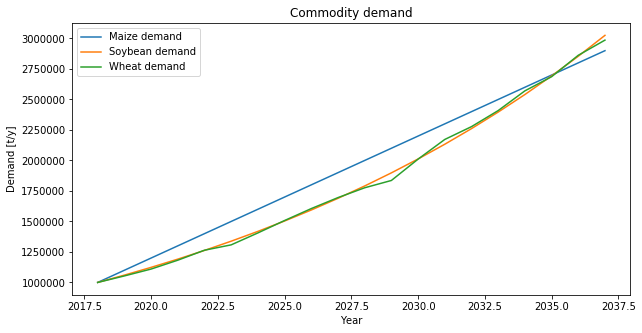

In [33]:
vessels, commodities = scenario_generator(start_year, simulation_window)

### Specify terminal status @ t=0

In [38]:
terminal = Terminal()

terminal.quays.append(infra.quay_object)      
terminal.berths.append(infra.berth_object)     
terminal.cranes.append(infra.cranes_object[0])     
terminal.cranes.append(infra.cranes_object[1])     
terminal.cranes.append(infra.cranes_object[2])     
terminal.cranes.append(infra.cranes_object[3])     
terminal.storages.append(infra.storage_object[0]) 
terminal.storages.append(infra.storage_object[1]) 
terminal.stations.append(infra.station_object)   
terminal.q_conveyors.append(infra.quay_conveyor_object) 
terminal.h_conveyors.append(infra.hinterland_conveyor_object)

terminal.throughputs, terminal.revenues, terminal.capex, terminal.labour, terminal.maintenance, energy,\
    terminal.insurance, terminal.lease, terminal.demurrage, terminal.residuals, terminal.profits, terminal.opex = \
    [], [], [], [], [], [], [], [], [], [], [], []

# 2. Perform simulation

In [35]:
terminal = simulator(start_year, simulation_window, operational_hours, vessels, commodities, terminal)

AttributeError: 'Terminal' object has no attribute 'berth_objects'

# 4 Preliminary Plots
### Profit/loss

In [ ]:
# Plotting annualised profits
plot_file.profit_loss(profits, 10, 5)

### Annual cashflows

In [ ]:
# Plotting yearly cashflows
plot_file.all_cashflows(revenues, capex, labour, maintenance, energy, insurance, demurrage, residuals, 10, 5)

### Demand vs. Capacity

In [ ]:
# Plotting capacity vs. demand 
plot_file.throughput(commodities, throughputs, 10, 5)

# 5 NPV

In [ ]:
#NPV = financial.NPV_calc(profits_WACC)
#NPV

In [ ]:
from terminal_optimization.infrastructure import quay_object

# simulation parameters (year, window, triggers)

# generate trend

# define port at t =0
terminal.quays = []
terminal.berths = []

# business logic
terminal = simulate(year, window, trend, terminal)        

# postprocessing
npv = npv(terminal)

# plotting
terminal_optimization.plot.cashflow_overview(terminal.quays[0])